<a href="https://www.kaggle.com/code/thirumani/predicting-bigg-boss-marathi-season-4-winner?scriptVersionId=114856302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Predicting Marathi Bigg Boss (बिग बॉस मराठी) 4 Season Winner

## Dataset https://www.kaggle.com/datasets/thirumani/bigg-boss-india-hindi-telugu-tamil-kannada

In [1]:
from IPython.display import IFrame
import datetime
print("Notebook was last executed on:", datetime.date.today().strftime("%Y-%b-%d"))

Notebook was last executed on: 2022-Dec-27


In [2]:
# Source: Wikipedia
IFrame('https://upload.wikimedia.org/wikipedia/en/0/01/Bigg_Boss_Marathi_4_Logo.jpg', width=560, height=270)

### Importing Required Python Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
import seaborn as sns
from babel.numbers import format_currency
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

### Check and import dataset

In [4]:
! ls -l /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv
bigg_boss = pd.read_csv('/kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv', encoding = "ISO-8859-1")

nRow, nCol = bigg_boss.shape
print(f'\nThere are {nRow} rows and {nCol} columns in the dataset')

-rw-r--r-- 1 nobody nogroup 181916 Dec 27 13:59 /kaggle/input/bigg-boss-india-hindi-telugu-tamil-kannada/Bigg_Boss_India.csv

There are 939 rows and 31 columns in the dataset


## 🌟 Exploratory Data Analysis (EDA)

In [5]:
bigg_boss.head(5)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner
0,Hindi,1,Amit Sadh,Soap Actor,Male,03-Nov-06,NaN,10.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0.0,0,0,0,NaN,NaN,0.0,0.0
1,Hindi,1,Anupama Verma,Model,Female,03-Nov-06,NaN,5.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0.0,0,0,0,NaN,NaN,0.0,0.0
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,03-Nov-06,NaN,4.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0.0,0,0,0,NaN,NaN,0.0,0.0
3,Hindi,1,Bobby Darling,Activist,Transgender,03-Nov-06,NaN,1.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0.0,0,0,0,NaN,NaN,0.0,0.0
4,Hindi,1,Carol Gracias,Model,Female,03-Nov-06,26-Jan-07,12.0,No,86,15,03-Nov-06,26-Jan-07,Arshad Warsi,NaN,0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0.0,0,0,0,NaN,NaN,1.0,0.0


In [6]:
bigg_boss.tail(10).T

,929,930,931,932,933,934,935,936,937,938
Language,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam,Malayalam
Season Number,4,4,4,4,4,4,4,4,4,4
Name,Naveen Arakkal,Nimisha,Robin Radhakrishnan,Ronson Vincent,Shalini Nair,Sooraj Thelakkad,Suchithra Nair,Manikandan Thonnakkal,Riyas Salim,Vinay Madhav
Profession,Soap Actor,Model,Doctor,Soap Actor,Video Jockey,Comedian,Soap Actress,Social Media Star,Social Media Star,Social Media Star
Gender,Male,Female,Male,Male,Female,Male,Female,Male,Male,Male
Entry Date,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,27-Mar-22,NaN,NaN,NaN
Elimination Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elimination Week Number,5.0,7.0,10.0,13.0,3.0,14.0,9.0,4.0,14.0,12.0
Wild Card,No,No,No,No,No,No,No,Yes,Yes,Yes
Season Length,98,98,98,98,98,98,98,98,98,98


In [7]:
bigg_boss.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner
695,Tamil,4,Somshekar,Model,Male,04-Oct-20,17-Jan-21,15.0,No,105,18,04-Oct-20,17-Jan-21,Kamal Haasan,NaN,0,Star Vijay,Disney+ Hotstar,15.60,Tamil Nadu,Chennai,No,10,0.0,0,0,0,NaN,6.0,1.0,0.0
825,Marathi,4,Snehlata Vasaikar,Actress,Female,NaN,NaN,10.0,Yes,98,21,02-Oct-22,08-Jan-23,Mahesh Manjrekar,NaN,0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,2,0.0,0,0,0,NaN,NaN,0.0,0.0
919,Malayalam,4,Akhil Kutty,Comedian,Male,27-Mar-22,NaN,11.0,No,98,20,27-Mar-22,03-Jul-22,Mohanlal,NaN,0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,5,3.0,0,0,0,NaN,NaN,0.0,0.0
253,Hindi,14,Rubina Dilaik,Soap Actress,Female,03-Oct-20,NaN,NaN,No,142,22,03-Oct-20,21-Feb-21,Salman Khan,NaN,"36,00,000",Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,14,1.0,0,0,0,NaN,9.0,1.0,1.0
332,Kannada,1,Vijay Raghavendra,Actor,Male,24-Mar-13,NaN,NaN,No,98,15,24-Mar-13,30-Jun-13,Sudeep,NaN,"50,00,000",ETV Kannada,NaN,4.70,Karnataka,Lonavala,No,6,NaN,0,0,0,NaN,NaN,1.0,1.0
217,Hindi,12,Shivashish Mishra,Entrepreneur,Male,16-Sep-18,NaN,9.0,No,105,20,16-Sep-18,30-Dec-18,Salman Khan,NaN,0,Colors,NaN,4.99,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1.0,0,1,0,NaN,NaN,0.0,0.0
805,Marathi,3,Vikas Patil,Soap Actor,Male,19-Sep-21,NaN,14.0,No,98,17,19-Sep-21,26-Dec-21,Mahesh Manjrekar,Siddhartha Jadhav,0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,11,0.0,0,0,0,NaN,7.0,1.0,0.0
699,Tamil,4,Suchitra Ramadurai,Singer,Female,NaN,NaN,7.0,Yes,105,18,04-Oct-20,17-Jan-21,Kamal Haasan,NaN,0,Star Vijay,Disney+ Hotstar,15.60,Tamil Nadu,Chennai,No,2,0.0,0,0,0,NaN,NaN,0.0,0.0
545,Telugu,3,Rohini,Soap Actress,Female,21-Jul-19,18-Aug-19,4.0,No,105,17,21-Jul-19,03-Nov-19,Nagarjuna,Ramya Krishnan,0,Star Maa,Disney+ Hotstar,18.10,"Telangana, Andhra Pradesh",Hyderabad,No,1,0.0,0,0,0,NaN,NaN,0.0,0.0
618,Telugu,6,Marina Abraham,Soap Actress,Female,04-Sep-22,19-Nov-22,11.0,No,105,21,04-Sep-22,18-Dec-22,Nagarjuna,NaN,0,Star Maa,Disney+ Hotstar,NaN,"Telangana, Andhra Pradesh",Hyderabad,No,8,0.0,0,0,0,NaN,NaN,0.0,0.0


In [8]:
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Language                            939 non-null    object 
 1   Season Number                       939 non-null    object 
 2   Name                                939 non-null    object 
 3   Profession                          939 non-null    object 
 4   Gender                              939 non-null    object 
 5   Entry Date                          811 non-null    object 
 6   Elimination Date                    187 non-null    object 
 7   Elimination Week Number             779 non-null    float64
 8   Wild Card                           939 non-null    object 
 9   Season Length                       939 non-null    int64  
 10  Number of Housemates                939 non-null    int64  
 11  Season Start Date                   939 non-n

In [9]:
bigg_boss.describe().T.round(2).style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
Elimination Week Number,779.000000,8.840000,4.790000,1.000000,5.000000,9.000000,13.000000,20.000000
Season Length,939.000000,99.540000,18.260000,28.000000,98.000000,105.000000,105.000000,142.000000
Number of Housemates,939.000000,18.390000,2.360000,10.000000,17.000000,18.000000,20.000000,24.000000
Average TRP,550.000000,9.150000,5.900000,2.720000,3.810000,7.800000,15.000000,20.400000
Number of Evictions Faced,939.000000,4.280000,2.970000,0.000000,2.000000,4.000000,6.000000,14.000000
Number of times elected as Captain,908.000000,0.570000,0.770000,0.000000,0.000000,0.000000,1.000000,5.000000
Number of re-entries,939.000000,0.100000,0.320000,0.000000,0.000000,0.000000,0.000000,2.000000
Walked,939.000000,0.080000,0.260000,0.000000,0.000000,0.000000,0.000000,1.000000
Ejected,939.000000,0.040000,0.190000,0.000000,0.000000,0.000000,0.000000,1.000000
In secret room,34.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
bigg_boss['Season Start Date'] = pd.to_datetime(bigg_boss['Season Start Date'])
bigg_boss['Season End Date'] = pd.to_datetime(bigg_boss['Season End Date'])
bigg_boss['Entry Date'] = pd.to_datetime(bigg_boss['Entry Date'])
bigg_boss['Elimination Date'] = pd.to_datetime(bigg_boss['Elimination Date'])

In [11]:
bigg_boss['Finalist'] = bigg_boss['Finalist'].astype(pd.Int32Dtype())
bigg_boss['Elimination Week Number'] = bigg_boss['Elimination Week Number'].astype(pd.Int32Dtype())
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].astype(pd.Int32Dtype())
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].astype(pd.Int32Dtype())
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].astype(pd.Int32Dtype())
bigg_boss['Social Media Popularity'] = bigg_boss['Social Media Popularity'].astype(pd.Int32Dtype())

bigg_boss['Prize Money (INR)'] = bigg_boss['Prize Money (INR)'].str.replace(',','')
bigg_boss['Prize Money (INR)'] = pd.to_numeric(bigg_boss['Prize Money (INR)'])

bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 31 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            939 non-null    object        
 1   Season Number                       939 non-null    object        
 2   Name                                939 non-null    object        
 3   Profession                          939 non-null    object        
 4   Gender                              939 non-null    object        
 5   Entry Date                          811 non-null    datetime64[ns]
 6   Elimination Date                    187 non-null    datetime64[ns]
 7   Elimination Week Number             779 non-null    Int32         
 8   Wild Card                           939 non-null    object        
 9   Season Length                       939 non-null    int64         
 10  Number of Housemates      

In [12]:
# Unique values in each column
for col in bigg_boss.columns:
    print("Number of unique values in", col, "-", bigg_boss[col].nunique())

Number of unique values in Language - 7
Number of unique values in Season Number - 20
Number of unique values in Name - 876
Number of unique values in Profession - 80
Number of unique values in Gender - 4
Number of unique values in Entry Date - 61
Number of unique values in Elimination Date - 114
Number of unique values in Elimination Week Number - 20
Number of unique values in Wild Card - 2
Number of unique values in Season Length - 19
Number of unique values in Number of Housemates - 11
Number of unique values in Season Start Date - 52
Number of unique values in Season End Date - 50
Number of unique values in Host Name - 15
Number of unique values in Guest Host Name - 7
Number of unique values in Prize Money (INR) - 15
Number of unique values in Broadcasted By - 12
Number of unique values in OTT Platform - 2
Number of unique values in Average TRP - 29
Number of unique values in Most Viewed States - 7
Number of unique values in House Location - 6
Number of unique values in OTT Season 

In [13]:
# Number of seasons in all Indian languages
print("Total", bigg_boss.groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted (in TV & OTT)")
print(bigg_boss['Winner'].sum().astype(int) + 2, "seasons completed")
print(bigg_boss.loc[bigg_boss['Winner'].isnull(), :].groupby('Language')['Season Number'].nunique().sum(), "season(s) running")

# For Bigg Boss Hindi season 8 & Malayalam season 2 winner was not declared

Total 52 seasons broadcasted (in TV & OTT)
48 seasons completed
4 season(s) running


In [14]:
# Seasons broadcasted ONLY in OTT platforms, eventually in Television
print(bigg_boss.loc[bigg_boss['OTT Season']=='Yes'].groupby('Language')['Season Number'].nunique().sum(), "seasons broadcasted ONLY in OTT platforms")

4 seasons broadcasted ONLY in OTT platforms


## 📊 Bigg Boss Hindi has many seasons compared to other Indian languages. So, the number of housemates are more in Hindi.

In [15]:
# Number of seasons in each Indian language
print(bigg_boss.groupby('Language')['Season Number'].nunique().nlargest(10))

Language
Hindi        18
Kannada      10
Tamil         7
Telugu        7
Malayalam     4
Marathi       4
Bengali       2
Name: Season Number, dtype: int64


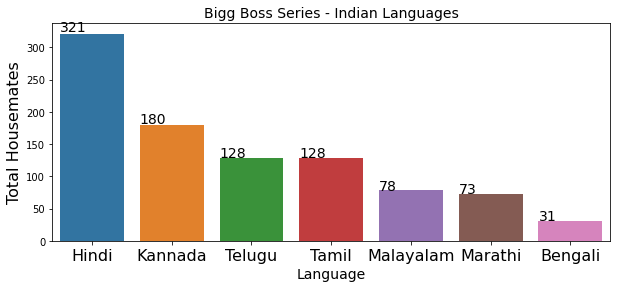

In [16]:
# Total number of Bigg Boss housemates, language wise
fig = plt.figure(figsize=(10, 4))
ax = sns.countplot(x='Language', data=bigg_boss, order=bigg_boss['Language'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian Languages', fontsize=14)
plt.xticks(fontsize=16)
plt.xlabel("Language", fontsize=14)
plt.ylabel("Total Housemates", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

## In Bigg Boss India seasons, most of the housemates entered in first day/week

No     800
Yes    139
Name: Wild Card, dtype: int64 

No     85%
Yes    15%
Name: Wild Card, dtype: object 



<AxesSubplot:ylabel='Wild Card'>

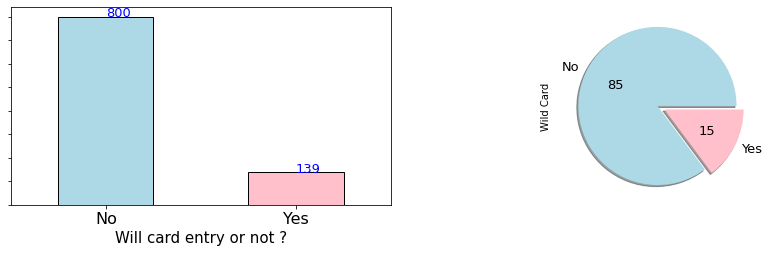

In [17]:
# Number of normal entries and wild card entries
print(bigg_boss['Wild Card'].value_counts(), "\n")
print(round(bigg_boss['Wild Card'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'), "\n")

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss['Wild Card'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Will card entry or not ?", fontsize=15)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss['Wild Card'].value_counts()):
    plt.annotate(y, (x,y), fontsize=13, color="blue")
    
ax2=plt.subplot(222)
bigg_boss['Wild Card'].value_counts().plot(kind='pie', autopct='%.0f', explode=(0,0.10), colors=["lightblue","pink"], shadow=True, fontsize=13)

In [18]:
# Common people has many professions, so clubbing them into one category
bigg_boss['Profession'] = bigg_boss['Profession'].fillna('UNKNOWN')
bigg_boss.loc[bigg_boss['Profession'].str.contains('Commoner'),'Profession'] = 'Commoner'

## 💚 Number of film actresses entered into the Bigg Boss houses, are more when compared to other professions

Actress                  189
Actor                    128
Soap Actress              94
Model                     67
Singer                    57
Soap Actor                56
Commoner                  40
Social Media Star         33
Comedian                  32
TV Anchor                 28
Reality Show Alumni       27
Radio Jockey              21
Choreographer             19
Activist                  17
News Presenter            17
Pageant Winner            12
Sports Person             10
Video Jockey               8
Film Director              8
International Star         6
Politician                 6
Dancer                     5
Entrepreneur               4
Swamiji                    4
Controversial Fame         4
Producer                   3
Wrestler                   3
Musician                   3
Numerologist               3
Stage Actress              2
Doctor                     2
Folk Artist                2
Lyricist                   2
Journalist                 2
Film director 

Text(0, 0.5, 'Count')

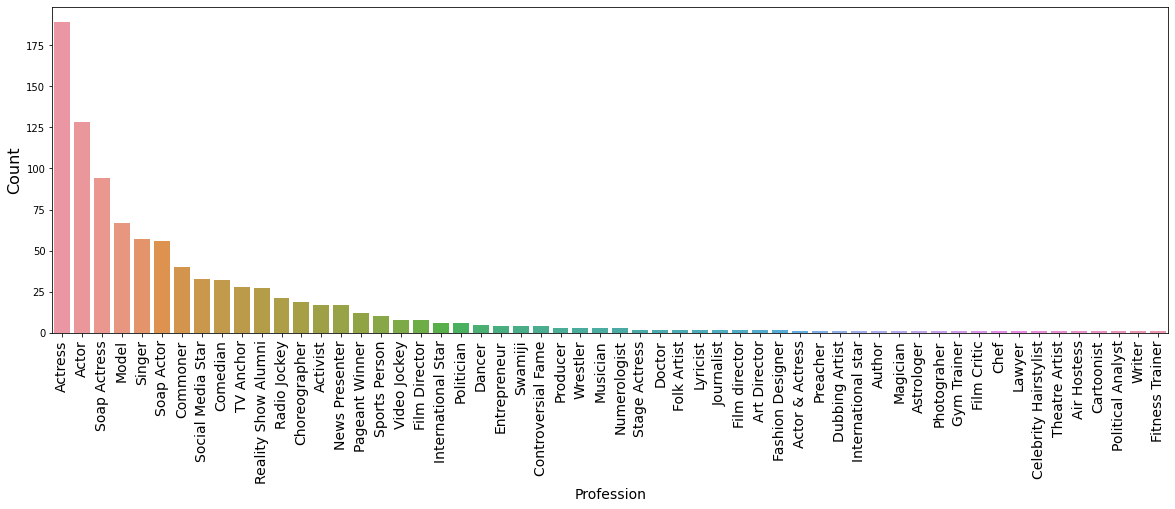

In [19]:
# Participant's Profession
print(bigg_boss['Profession'].value_counts())
fig = plt.figure(figsize=(20, 6))
sns.countplot(x='Profession', data=bigg_boss, order=bigg_boss['Profession'].value_counts().index)
plt.xticks(fontsize=14, rotation=90)
plt.xlabel("Profession", fontsize=14)
plt.ylabel("Count", fontsize=16)

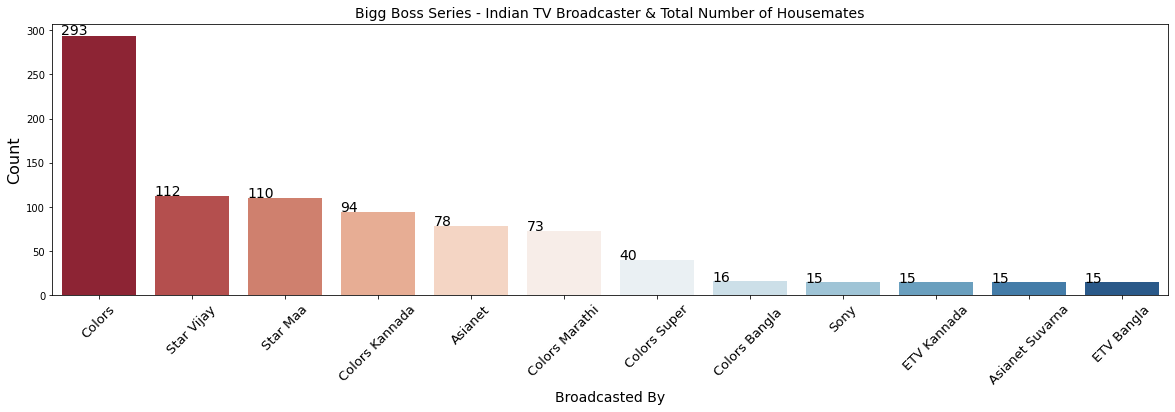

In [20]:
# TV Broadcaster
fig = plt.figure(figsize=(20, 5))
ax = sns.countplot(x='Broadcasted By', data=bigg_boss, palette='RdBu', order=bigg_boss['Broadcasted By'].value_counts().index)
ax.set_title('Bigg Boss Series - Indian TV Broadcaster & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=13, rotation=45)
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("Count", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

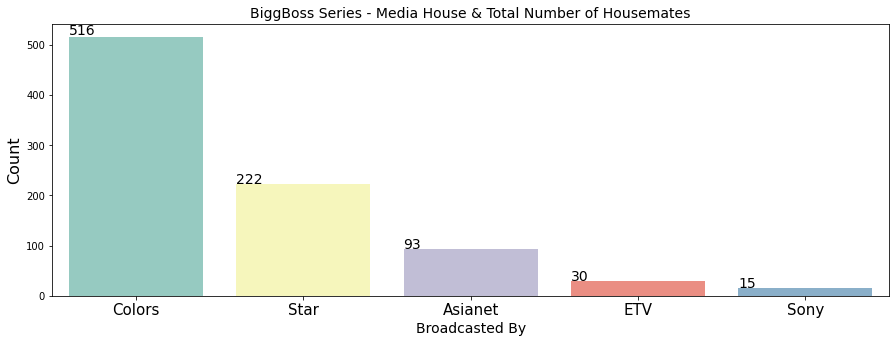

In [21]:
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star'), data=bigg_boss, palette='Set3', order=bigg_boss['Broadcasted By'].str.split().str.get(0).replace('Disney+', 'Star').value_counts().index)
ax.set_title('BiggBoss Series - Media House & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=15)
plt.xlabel("Broadcasted By", fontsize=14)
plt.ylabel("Count", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

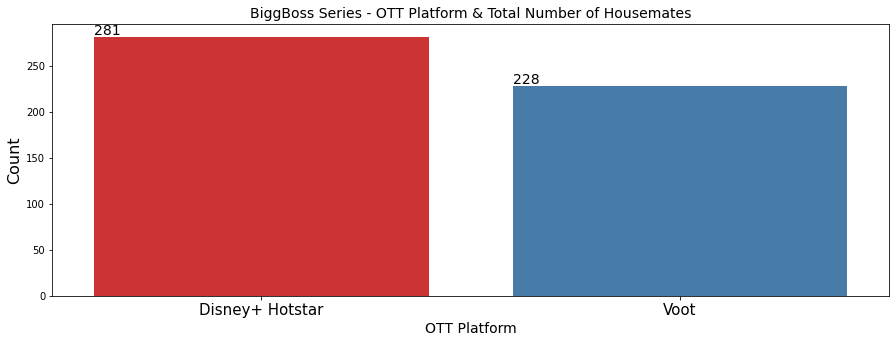

In [22]:
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(bigg_boss['OTT Platform'], data=bigg_boss, palette='Set1', order=bigg_boss['OTT Platform'].value_counts().index)
ax.set_title('BiggBoss Series - OTT Platform & Total Number of Housemates', fontsize=14)
plt.xticks(fontsize=15)
plt.xlabel("OTT Platform", fontsize=14)
plt.ylabel("Count", fontsize=16)
for t in ax.patches:
    if (np.isnan(float(t.get_height()))):
        ax.annotate(0, (t.get_x(), 0))
    else:
        ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01), size=14)

## Salman Khan hosted most number of seasons (in Bigg Boss Hindi), Sudeep is next on the list

In [23]:
# Bigg Boss main hosts and number of seasons they hosted
bigg_boss.groupby('Host Name')['Season Number'].nunique().nlargest(25)

Host Name
Salman Khan            13
Sudeep                 10
Kamal Haasan            7
Nagarjuna               5
Mahesh Manjrekar        4
Mohanlal                4
Amitabh Bachchan        1
Arshad Warsi            1
Farah Khan              1
Jeet                    1
Jr. NTR                 1
Karan Johar             1
Mithun Chakraborthy     1
Nani                    1
Shilpa Shetty           1
Name: Season Number, dtype: int64

In [24]:
# Temporary or Guest host who hosted the week-end episodes
bigg_boss.groupby('Guest Host Name')['Season Number'].nunique().nlargest(10)

Guest Host Name
Ramya Krishnan       2
Farah Khan           1
Karan Johar          1
Samantha             1
Sanjay Dutt          1
Siddhartha Jadhav    1
Simbu                1
Name: Season Number, dtype: int64

## 👩 In all Bigg Boss competitions, in languages and in all seasons, Female contestants are more

Female         487
Male           443
Transgender      7
Pair             2
Name: Gender, dtype: int64 

Female         52%
Male           47%
Transgender     1%
Pair            0%
Name: Gender, dtype: object


Text(0, 0.5, 'Count')

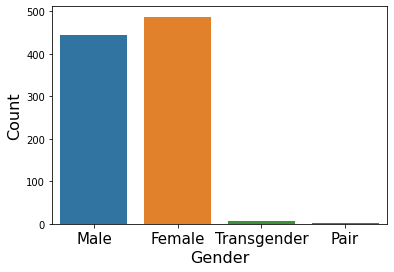

In [25]:
# Housemate's Gender
print(bigg_boss['Gender'].value_counts(), "\n")

# In percentage
print(round(bigg_boss['Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

sns.countplot(data = bigg_boss, x = 'Gender')
plt.xticks(fontsize=15)
plt.xlabel("Gender", fontsize=16)
plt.ylabel("Count", fontsize=16)

### 7️⃣ Transgenders (LGBT) participated in all Indian languages

In [26]:
# Maximum TRP of Bigg Boss India seasons (Big Brother in India)
print("Maximum TRP", bigg_boss['Average TRP'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Average TRP']==bigg_boss['Average TRP'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum TRP 20.4 

Language Season Number
   Tamil             6


In [27]:
# Smallest season of Indian Bigg Boss seasons
print("Smallest season", bigg_boss['Season Length'].min(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].min()][["Language","Season Number"]].head(1).to_string(index=False))

Smallest season 28 days 

Language Season Number
   Hindi     Halla Bol


In [28]:
# Longest season of Bigg Boss Indian seasons
print("Longest season", bigg_boss['Season Length'].max(), "days \n")
print(bigg_boss.loc[bigg_boss['Season Length']==bigg_boss['Season Length'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Longest season 142 days 

Language Season Number
   Hindi            14


## 🎆 Shark Tank India data set https://www.kaggle.com/datasets/thirumani/shark-tank-india

In [29]:
print("Maximum number of contestants in one season:", bigg_boss['Number of Housemates'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of Housemates']==bigg_boss['Number of Housemates'].max()][["Language","Season Number"]].head(1).to_string(index=False))

Maximum number of contestants in one season: 24 

Language Season Number
   Hindi            15


In [30]:
print("Maximum number of evictions faced in one season:", bigg_boss['Number of Evictions Faced'].max(), "\n")
print("\nTop 4 contestants who faced highest/maximum number of evictions\n")
print(bigg_boss.loc[bigg_boss['Number of Evictions Faced']>=bigg_boss['Number of Evictions Faced'].max()-1][["Language","Season Number","Name","Number of Evictions Faced"]].head(10).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))

Maximum number of evictions faced in one season: 14 


Top 4 contestants who faced highest/maximum number of evictions

Language Season Number               Name  Number of Evictions Faced
   Hindi            14      Rubina Dilaik                         14
 Kannada             8 Prashanth Sambargi                         14
   Hindi            13         Arti Singh                         13
 Kannada             7      Chandan Achar                         13


In [31]:
bigg_boss['Season Length in weeks'] = round(bigg_boss['Season Length']/7,0).astype(pd.Int32Dtype())
bigg_boss['Evictions Faced Percentage'] = round(bigg_boss['Number of Evictions Faced']/bigg_boss['Season Length in weeks']*100,0).astype(pd.Int32Dtype())
print("Maximum percentage of evictions faced in one season:", bigg_boss['Evictions Faced Percentage'].max(), "%\n")
print("\nTop 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)\n")
print(bigg_boss.loc[bigg_boss['Evictions Faced Percentage']>=bigg_boss['Evictions Faced Percentage'].max()-10][["Language","Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(8).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))

Maximum percentage of evictions faced in one season: 100 %


Top 5 contestants who faced maximum percentage of evictions (they were in nominations almost every week)

Language Season Number               Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
   Hindi     Halla Bol      Dimpy Ganguly                          4                       4                         100
   Hindi     Halla Bol     Sambhavna Seth                          4                       4                         100
 Kannada           OTT Jayashree Aradhaya                          6                       6                         100
   Tamil      Ultimate      Maria Juliana                         10                      10                         100
  Telugu      Non-Stop     Mitraaw Sharma                         11                      12                          92


In [32]:
print("Maximum number of re-entries:", bigg_boss['Number of re-entries'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of re-entries']>=bigg_boss['Number of re-entries'].max()][["Language","Season Number","Name","Number of re-entries"]].head(5).sort_values("Number of re-entries",ascending=False).to_string(index=False))

Maximum number of re-entries: 2 

Language Season Number             Name  Number of re-entries
   Hindi             2 Raja Chaudhary                       2
   Hindi            10   Priyanka Jagga                     2
   Hindi            14      Vikas Gupta                     2
   Hindi            16       Tina Datta                     2
  Telugu             1     Mumaith Khan                     2


In [33]:
print("Maximum number of times elected as captain:", bigg_boss['Number of times elected as Captain'].max(), "\n")
print(bigg_boss.loc[bigg_boss['Number of times elected as Captain']>=bigg_boss['Number of times elected as Captain'].max()-1][["Language","Season Number","Name","Number of times elected as Captain"]].head(8).sort_values("Number of times elected as Captain",ascending=False).to_string(index=False))

Maximum number of times elected as captain: 5 

 Language Season Number              Name  Number of times elected as Captain
    Hindi            12       Surbhi Rana                                   5
    Hindi             1         Rahul Roy                                   4
    Hindi             9     Prince Narula                                   4
    Tamil             6 Manikandan Rajesh                                   4
Malayalam             2     Saju Navodaya                                   4


In [34]:
# Number of seasons in Bigg Boss house location
print(bigg_boss.groupby('House Location')['Season Number'].nunique().nlargest(10))

House Location
Lonavala     12
Bengaluru     8
Mumbai        8
Chennai       7
Hyderabad     6
Karjat        1
Name: Season Number, dtype: int64


In [35]:
# 69 persons walked out from the BB houses, due to health/personal reasons
print(bigg_boss.loc[bigg_boss['Walked']==1]['Name'].nunique())
bigg_boss.loc[bigg_boss['Walked']==1]

69


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1,0,NaN,<NA>,1,1.0,14,36
19,Hindi,2,Jade Goody,International Star,Female,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,1,0,NaN,<NA>,0,0.0,14,0
23,Hindi,2,Rahul Mahajan,Politician,Male,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1,1,NaN,<NA>,0,0.0,14,36
24,Hindi,2,Raja Chaudhary,Actor,Male,2008-08-17,2008-11-22,14,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,0,2,1,0,1.0,<NA>,1,0.0,14,43
28,Hindi,2,Zulfi Syed,Model,Male,2008-08-17,2008-11-22,14,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,0,1,1,0,NaN,<NA>,1,0.0,14,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899,Malayalam,2,Pavan Gino Thomas,Model,Male,NaT,NaT,<NA>,Yes,75,22,2020-01-05,2020-03-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,11.03,Kerala,Chennai,No,0,0,0,1,0,NaN,<NA>,0,0.0,11,0
904,Malayalam,3,Dimpal Bhal,Social Media Star,Female,2021-02-14,NaT,<NA>,No,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,12.40,Kerala,Chennai,No,7,0,1,1,0,NaN,7,1,0.0,14,50
908,Malayalam,3,Manikuttan,Actor,Male,2021-02-14,NaT,<NA>,No,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,7500000.0,Asianet,Disney+ Hotstar,12.40,Kerala,Chennai,No,5,2,1,1,0,NaN,9,1,1.0,14,36
926,Malayalam,4,Jasmine M Moosa,Fitness Trainer,Female,2022-03-27,NaT,10,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,5,1,0,1,0,NaN,<NA>,0,0.0,14,36


In [36]:
# 35 persons ejected from the BB houses, due to violation/legal issues
print(bigg_boss.loc[bigg_boss['Ejected']==1]['Name'].nunique())
bigg_boss.loc[bigg_boss['Ejected']==1]

35


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,2006-11-03,NaT,1,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,0,1,NaN,<NA>,0,0.0,12,0
23,Hindi,2,Rahul Mahajan,Politician,Male,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1,1,NaN,<NA>,0,0.0,14,36
35,Hindi,3,Kamal Rashid Khan,Film Director,Male,2009-10-04,NaT,2,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,3,0,1,0,1,NaN,<NA>,0,0.0,12,25
49,Hindi,4,Devinder Singh,Controversial Fame,Male,2010-10-03,NaT,1,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,1,0,0,1,NaN,<NA>,0,0.0,14,7
54,Hindi,4,Samir Soni,Actor,Male,2010-10-03,NaT,13,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,0,1,0,1,NaN,<NA>,0,0.0,14,43
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1,1,0,1,NaN,<NA>,1,0.0,14,29
68,Hindi,5,Pooja Mishra,Reality Show Alumni,Female,2011-10-02,NaT,<NA>,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,6,1,1,0,1,NaN,<NA>,0,0.0,14,43
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,1,0,1,1.0,<NA>,1,0.0,14,36
105,Hindi,7,Kushal Tandon,Model,Male,2013-09-15,NaT,14,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,8,1,1,0,1,NaN,<NA>,0,0.0,15,53
127,Hindi,8,Puneet Issar,Actor,Male,2014-09-21,2015-01-03,15,No,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,1,1,0,1,NaN,<NA>,1,0.0,15,47


In [37]:
# Many contestants entered via wild card, but 24 people managed to go to Finale
print(bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Finalist'].value_counts())
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), :]

1    24
Name: Finalist, dtype: Int64


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
44,Hindi,3,Pravesh Rana,Model,Male,NaT,NaT,12,Yes,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,0,0,0,0,NaN,<NA>,1,0.0,12,33
59,Hindi,4,Dalip Singh Rana (Khali),Wrestler,Male,NaT,2011-01-08,14,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,2,0,0,0,NaN,<NA>,1,0.0,14,29
60,Hindi,4,Dolly Bindra,Actress,Female,NaT,2011-01-08,14,Yes,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1,1,0,1,NaN,<NA>,1,0.0,14,29
75,Hindi,5,Amar Upadhyay,Soap Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,7,1,0,0,0,NaN,<NA>,1,0.0,14,50
76,Hindi,5,Siddharth Bhardwaj,Reality Show Alumni,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,5,1,0,0,0,NaN,<NA>,1,0.0,14,36
77,Hindi,5,Akashdeep Saigal,Soap Actor,Male,NaT,2012-01-07,14,Yes,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,5,1,0,0,0,NaN,<NA>,1,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,1,0,1,1.0,<NA>,1,0.0,14,36
115,Hindi,7,Ajaz Khan,Actor,Male,NaT,2013-12-28,15,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,0,0,0,0,NaN,<NA>,1,0.0,15,47
133,Hindi,8,Ali Quli Mirza,Singer,Male,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,3,0,0,0,NaN,<NA>,1,0.0,15,40
135,Hindi,8,Dimpy Ganguly,Soap Actress,Female,NaT,2015-01-03,15,Yes,105,19,2014-09-21,2015-01-03,Salman Khan,Farah Khan,0.0,Colors,NaN,3.77,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,0,0,0,NaN,<NA>,1,0.0,15,33


In [38]:
# Number of Wild card entries went to Finale, as per Language
bigg_boss.loc[(bigg_boss['Wild Card']=='Yes') & (bigg_boss['Finalist']==1), 'Language'].value_counts()

Hindi        14
Tamil         4
Telugu        2
Marathi       2
Malayalam     2
Name: Language, dtype: int64

In [39]:
# Persons who participated in more than one season (in same/different languages)
print(bigg_boss.groupby('Name')['Season Number'].nunique().nlargest(60))
bigg_boss[bigg_boss.groupby('Name')['Season Number'].transform('size')>1] [["Name", "Language", "Season Number"]].sort_values(by=['Name','Season Number'], ascending=True)

Name
Rakhi Sawant              4
Shamita Shetty            3
Abhijit Bichukale         2
Abhinay Vaddi             2
Abhirami Venkatachalam    2
Ajaz Khan                 2
Akhil Sarthak             2
Ali Quli Mirza            2
Anitha Sampath            2
Anupama Gowda             2
Ariyana Glory             2
Aroh Velankar             2
Arshi Khan                2
Arun Sagar                2
Aryavardhan Guruji        2
Ashu Reddy                2
Baba Bhaskar              2
Balaji Murugadoss         2
Bindu Madhavi             2
Deepika Das               2
Dimpy Ganguly             2
Divya Uruduga             2
Gautam Gulati             2
Hamida Khatoon            2
Karishma Tanna            2
Mahek Chahal              2
Mahesh Vitta              2
Manu Punjabi              2
Maria Juliana             2
Megha Dhade               2
Mira Jagannath            2
Mumaith Khan              2
Nataraj                   2
Neha Bhasin               2
Neha Gowda                2
Niroop Nandhaku

,Name,Language,Season Number
298,Abhijit Bichukale,Hindi,15
775,Abhijit Bichukale,Marathi,2
700,Abhinay Vaddi,Tamil,5
720,Abhinay Vaddi,Tamil,Ultimate
665,Abhirami Venkatachalam,Tamil,3
...,...,...,...
733,Vanitha Vijayakumar,Tamil,Ultimate
201,Vikas Gupta,Hindi,11
261,Vikas Gupta,Hindi,14
806,Vishal Nikam,Marathi,3


In [40]:
# Persons who participated in more than one language
bigg_boss.groupby('Name')['Language'].nunique().nlargest(4)

Name
Abhijit Bichukale    2
Bindu Madhavi        2
Megha Dhade          2
Rakhi Sawant         2
Name: Language, dtype: int64

In [41]:
# 17 housemates eliminated or walked without facing even single nomination 
print(bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), 'Number of Evictions Faced'].value_counts())
bigg_boss.loc[(bigg_boss['Number of Evictions Faced']==0), :]

0    16
Name: Number of Evictions Faced, dtype: Int64


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
12,Hindi,1,Salil Ankola,Sports Person,Male,2006-11-03,NaT,1,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,0,1,NaN,<NA>,0,0.0,12,0
19,Hindi,2,Jade Goody,International Star,Female,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,1,0,NaN,<NA>,0,0.0,14,0
39,Hindi,3,Shamita Shetty,Actress,Female,2009-10-04,NaT,<NA>,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,0.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,0,0,1,0,NaN,<NA>,0,0.0,12,0
73,Hindi,5,Sonika Kaliraman,Wrestler,Female,2011-10-02,NaT,<NA>,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,0.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,0,0,0,1,0,NaN,<NA>,0,0.0,14,0
152,Hindi,9,Kishwer Merchant,Soap Actress,Female,2015-10-11,NaT,<NA>,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,0,2,0,1,0,NaN,<NA>,0,0.0,15,0
299,Hindi,15,Raqesh Bapat,Actor,Male,NaT,NaT,6,Yes,121,24,2021-10-02,2022-01-30,Salman Khan,NaN,0.0,Colors,Voot,NaN,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Mumbai,No,0,0,0,1,0,NaN,<NA>,0,0.0,17,0
353,Kannada,3,Huccha Venkat,Actor,Male,2015-10-25,NaT,<NA>,No,98,18,2015-10-25,2016-01-31,Sudeep,NaN,0.0,Colors Kannada,NaN,NaN,Karnataka,Bengaluru,No,0,0,0,0,1,NaN,<NA>,0,0.0,14,0
465,Kannada,8,Vyjayanthi Adiga,Actress,Female,NaT,NaT,6,Yes,117,20,2021-02-28,2021-08-08,Sudeep,NaN,0.0,Colors Kannada,Voot,NaN,Karnataka,Bengaluru,No,0,0,0,1,0,NaN,<NA>,0,0.0,17,0
710,Tamil,5,Namitha Marimuthu,Model,Transgender,2021-10-03,NaT,1,No,105,20,2021-10-03,2022-01-16,Kamal Haasan,Ramya Krishnan,0.0,Star Vijay,Disney+ Hotstar,18.60,Tamil Nadu,Chennai,No,0,0,0,1,0,NaN,<NA>,0,0.0,15,0
741,Tamil,6,GP Muthu,Social Media Star,Male,2022-10-09,NaT,2,No,105,21,2022-10-09,2023-01-21,Kamal Haasan,NaN,0.0,Star Vijay,Disney+ Hotstar,20.40,Tamil Nadu,Chennai,No,0,1,0,1,0,NaN,<NA>,0,0.0,15,0


In [42]:
# Only two pairs entered into BB houses
bigg_boss.loc[(bigg_boss['Gender']=="Pair"), :]

# Many other couples entered into Bigg Boss, but as individual contestants

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
900,Malayalam,2,Abhirami Suresh & Amrutha Suresh,Singer,Pair,NaT,NaT,<NA>,Yes,75,22,2020-01-05,2020-03-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,11.03,Kerala,Chennai,No,3,0,0,0,0,NaN,<NA>,0,0.0,11,27
916,Malayalam,3,Firoz Khan & Sajna Firoz,Actor & Actress,Pair,NaT,NaT,9,Yes,95,18,2021-02-14,2021-05-20,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,12.40,Kerala,Chennai,No,7,0,0,0,1,NaN,<NA>,0,0.0,14,50


In [43]:
# 34 persons stayed in the BB house secret rooms
print(bigg_boss.loc[bigg_boss['In secret room']==1]['Name'].nunique())
bigg_boss.loc[bigg_boss['In secret room']==1]

34


,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
24,Hindi,2,Raja Chaudhary,Actor,Male,2008-08-17,2008-11-22,14,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,0.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,0,2,1,0,1.0,<NA>,1,0.0,14,43
55,Hindi,4,Sara Khan,Soap Actress,Female,2010-10-03,NaT,4,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,0.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,0,0,0,0,1.0,<NA>,0,0.0,14,29
79,Hindi,6,Aashka Goradia,Soap Actress,Female,2012-10-07,NaT,12,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1,1,0,0,1.0,<NA>,0,0.0,14,29
93,Hindi,6,Vrajesh Hirjee,Actor,Male,2012-10-07,NaT,9,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,1,1,0,0,1.0,<NA>,0,0.0,14,29
95,Hindi,6,Vishal Karwal,Soap Actor,Male,NaT,NaT,11,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,0,0,1.0,<NA>,0,0.0,14,36
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,1,0,1,1.0,<NA>,1,0.0,14,36
97,Hindi,6,Santosh Shukla,Actor,Male,NaT,NaT,11,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,3,0,0,0,0,1.0,<NA>,0,0.0,14,21
153,Hindi,9,Mandana Karimi,International Star,Female,2015-10-11,2016-01-23,15,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,0.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,12,0,0,0,0,1.0,<NA>,1,0.0,15,80
174,Hindi,10,Manu Punjabi,Reality Show Alumni,Male,2016-10-16,NaT,<NA>,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,4,0,1,1,0,1.0,<NA>,1,0.0,15,27
178,Hindi,10,Priyanka Jagga,Commoner,Female,2016-10-16,NaT,8,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,2,0,1,1.0,<NA>,0,0.0,15,13


In [44]:
# 5 housemates were ejected, but returned from secret room
bigg_boss.loc[(bigg_boss['In secret room']==1) & (bigg_boss['Ejected']==1)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
96,Hindi,6,Imam Siddique,Reality Show Alumni,Male,NaT,2013-01-12,14,Yes,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,0.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,1,0,1,1.0,<NA>,1,0.0,14,36
178,Hindi,10,Priyanka Jagga,Commoner,Female,2016-10-16,NaT,8,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,2,0,1,1.0,<NA>,0,0.0,15,13
181,Hindi,10,Swami Om,Swamiji,Male,2016-10-16,NaT,<NA>,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,1,1,1,1.0,<NA>,0,0.0,15,13
510,Telugu,1,Mumaith Khan,Actress,Female,2017-07-16,2017-09-03,7,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,NaN,15.00,"Telangana, Andhra Pradesh",Lonavala,No,3,1,2,0,1,1.0,<NA>,0,0.0,10,30
931,Malayalam,4,Robin Radhakrishnan,Doctor,Male,2022-03-27,NaT,10,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,NaN,Kerala,Mumbai,No,7,0,0,0,1,1.0,7,0,0.0,14,50


In [45]:
# Swami Om was the only participant, who walked out and ejected from house and went to secret room
bigg_boss.loc[(bigg_boss['In secret room']==1) & (bigg_boss['Ejected']==1) & (bigg_boss['Walked']==1)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
181,Hindi,10,Swami Om,Swamiji,Male,2016-10-16,NaT,<NA>,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,0.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,1,1,1,1.0,<NA>,0,0.0,15,13


## 🎉 About Winners only

In [46]:
print("Total Bigg Boss season winners", bigg_boss['Winner'].sum().astype(int), "(out of",bigg_boss['Finalist'].sum(),"finalists)")
# For Bigg Boss Hindi season 8 & Malayalam season 2 winner was not declared

Total Bigg Boss season winners 46 (out of 235 finalists)


In [47]:
# All BB Winners
bigg_boss.loc[bigg_boss.Winner==1]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
8,Hindi,1,Rahul Roy,Actor,Male,2006-11-03,NaT,<NA>,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,10000000.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,4,0,0,0,NaN,<NA>,1,1.0,12,8
16,Hindi,2,Ashutosh Kaushik,Reality Show Alumni,Male,2008-08-17,NaT,<NA>,No,98,15,2008-08-17,2008-11-22,Shilpa Shetty,NaN,10000000.0,Colors,NaN,2.89,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,1,1,0,NaN,<NA>,1,1.0,14,36
42,Hindi,3,Vindu Dara Singh,Actor,Male,2009-10-04,NaT,<NA>,No,84,15,2009-10-04,2009-12-26,Amitabh Bachchan,NaN,10000000.0,Colors,NaN,2.83,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,0,0,0,0,NaN,<NA>,1,1.0,12,58
57,Hindi,4,Shweta Tiwari,Soap Actress,Female,2010-10-03,NaT,<NA>,No,97,16,2010-10-03,2011-01-08,Salman Khan,NaN,10000000.0,Colors,NaN,4.95,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,2,0,0,0,NaN,<NA>,1,1.0,14,36
62,Hindi,5,Juhi Parmar,Soap Actress,Female,2011-10-02,NaT,<NA>,No,98,18,2011-10-02,2012-01-07,Salman Khan,Sanjay Dutt,10000000.0,Colors,NaN,4.19,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Karjat,No,4,1,0,0,0,NaN,<NA>,1,1.0,14,29
92,Hindi,6,Urvashi Dholakia,Soap Actress,Female,2012-10-07,NaT,<NA>,No,97,19,2012-10-07,2013-01-12,Salman Khan,NaN,5000000.0,Colors,NaN,3.81,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,1,0,0,0,NaN,<NA>,1,1.0,14,36
102,Hindi,7,Gauhar Khan,Actress,Female,2013-09-15,NaT,<NA>,No,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,5000000.0,Colors,NaN,4.40,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,2,1,1,0,NaN,<NA>,1,1.0,15,47
140,Hindi,Halla Bol,Gautam Gulati,Soap Actor,Male,2015-01-04,NaT,<NA>,No,28,10,2015-01-04,2015-01-31,Farah Khan,NaN,5000000.0,Colors,NaN,2.82,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0,0,NaN,<NA>,1,1.0,4,50
154,Hindi,9,Prince Narula,Reality Show Alumni,Male,2015-10-11,NaT,<NA>,No,105,20,2015-10-11,2016-01-23,Salman Khan,NaN,5000000.0,Colors,NaN,2.90,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,6,4,0,0,0,NaN,<NA>,1,1.0,15,40
175,Hindi,10,Manveer Gurjar,Commoner,Male,2016-10-16,NaT,<NA>,No,105,18,2016-10-16,2017-01-28,Salman Khan,NaN,5000000.0,Colors,NaN,3.54,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,3,0,0,0,NaN,8,1,1.0,15,47


In [48]:
# Sum of prize money won by all BB Season winners/participants, in India
print(format_currency(bigg_boss['Prize Money (INR)'].sum(), 'INR', locale='en_IN').replace(".00", ""))

# 24 crores and 11 lakh rupees

₹24,11,00,000


In [49]:
# Profession of BB Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Profession'].value_counts()

Actor                  10
Soap Actress            8
Actress                 6
Singer                  5
Soap Actor              4
Reality Show Alumni     3
Commoner                2
TV Anchor               2
Film Director           1
Comedian                1
Radio Jockey            1
Video Jockey            1
Model                   1
Pageant Winner          1
Name: Profession, dtype: int64

Male      32
Female    14
Name: Gender, dtype: int64 

Male      %%
Female    %%
Name: Gender, dtype: object


<AxesSubplot:ylabel='Gender'>

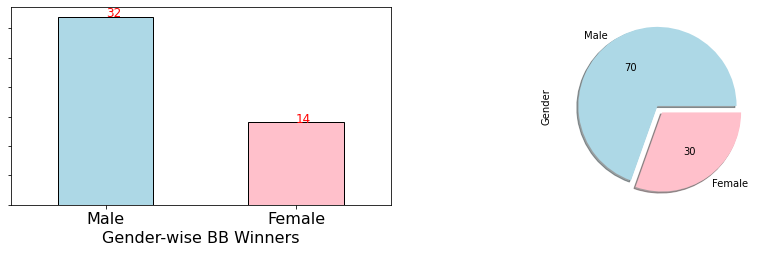

In [50]:
# Gender of Season title Winners
print(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(), '\n')

# In percentage
print(round(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts(normalize=True)*100).astype(str).str.replace('.0', '%'))

plt.figure(figsize=(15, 8))
ax1=plt.subplot(221)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='bar', color=["lightblue","pink"], ec="k")
plt.xlabel("Gender-wise BB Winners", fontsize=16)
plt.xticks(rotation=0, fontsize=16)
plt.setp(ax1.get_yticklabels(), visible=False)

for x,y in enumerate(bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts()):
    plt.annotate(y,(x,y),fontsize=12,color="Red")
    
ax2=plt.subplot(222)
bigg_boss.loc[bigg_boss.Winner==1, 'Gender'].value_counts().plot(kind='pie',autopct='%.0f',explode = (0, 0.10),colors=["lightblue","pink"],shadow=True)

## ➡️ No wild card entry housemate won the Bigg Boss competition.

In [51]:
# Entry type (wildcard or not) of the Season Winners
bigg_boss.loc[bigg_boss.Winner==1, 'Wild Card'].value_counts()

No    46
Name: Wild Card, dtype: int64

In [52]:
bigg_boss.loc[bigg_boss.Winner==1, 'Season Length'].value_counts().sort_index()

# Length of the season - Number of Winners

28      1
42      2
70      2
84      2
86      1
90      1
95      1
97      3
98     11
100     1
105    12
106     2
112     2
113     1
117     1
121     1
140     1
142     1
Name: Season Length, dtype: int64

In [53]:
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Housemates'].value_counts().sort_index()

# Number of Housemates in house - Number of Winners

10     1
13     1
15     6
16     5
17     5
18    10
19     5
20     9
21     2
22     1
24     1
Name: Number of Housemates, dtype: int64

In [54]:
# Number of eliminations or evictions faced by the Bigg Boss competition winners
bigg_boss.loc[bigg_boss.Winner==1, 'Number of Evictions Faced'].value_counts().sort_index()

# Number of eliminations faced - Number of Winners

1     1
2     2
4     4
5     7
6     7
7     7
8     4
9     6
10    2
11    1
12    4
14    1
Name: Number of Evictions Faced, dtype: Int64

In [55]:
# 4 re-entered contestant won Bigg Boss title
bigg_boss.loc[bigg_boss.Winner==1, 'Number of re-entries'].value_counts()

0    42
1     4
Name: Number of re-entries, dtype: Int64

In [56]:
# Bigg Boss title winners number of times elected as captain
bigg_boss.loc[bigg_boss.Winner==1, 'Number of times elected as Captain'].value_counts().sort_index()

# Number of times elected as Captain - Number of winners

0    12
1    13
2    15
3     2
4     2
Name: Number of times elected as Captain, dtype: Int64

## 🔵 BB Marathi Seasons

In [57]:
lang='Marathi'

# All Bigg Boss Marathi Participants
bigg_boss.loc[(bigg_boss['Language']==lang)]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
757,Marathi,1,Aarti Solanki,Comedian,Female,2018-04-15,NaT,1,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,14,7
758,Marathi,1,Aastad Kale,Actor,Male,2018-04-15,NaT,14,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,8,1,0,0,0,NaN,<NA>,1,0.0,14,57
759,Marathi,1,Anil Thatte,Journalist,Male,2018-04-15,NaT,4,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,3,0,0,0,0,NaN,<NA>,0,0.0,14,21
760,Marathi,1,Bhushan Kadu,Comedian,Male,2018-04-15,NaT,9,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,4,1,0,0,0,NaN,<NA>,0,0.0,14,29
761,Marathi,1,Jui Gadkari,Soap Actress,Female,2018-04-15,NaT,7,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,5,0,0,0,0,NaN,<NA>,0,0.0,14,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,Marathi,4,Snehlata Vasaikar,Actress,Female,NaT,NaT,10,Yes,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,0.0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,2,0,0,0,0,NaN,<NA>,0,0.0,14,14
826,Marathi,4,Aroh Velankar,Actor,Male,NaT,NaT,<NA>,Yes,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,2,0,0,0,0,NaN,<NA>,<NA>,NaN,14,14
827,Marathi,4,Mira Jagannath,Actress,Female,NaT,NaT,<NA>,Yes,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,0,0,0,0,0,NaN,<NA>,<NA>,NaN,14,0
828,Marathi,4,Rakhi Sawant,Actress,Female,NaT,NaT,<NA>,Yes,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,1,0,0,0,0,NaN,<NA>,<NA>,NaN,14,7


In [58]:
# Bigg Boss Marathi Winners
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
762,Marathi,1,Megha Dhade,Actress,Female,2018-04-15,NaT,<NA>,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,2500000.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,5,2,0,0,0,NaN,<NA>,1,1.0,14,36
784,Marathi,2,Shiv Thakre,Reality Show Alumni,Male,2019-05-26,NaT,<NA>,No,98,17,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,2500000.0,Colors Marathi,NaN,NaN,Maharashtra,Mumbai,No,7,2,0,0,0,NaN,<NA>,1,1.0,14,50
806,Marathi,3,Vishal Nikam,Soap Actor,Male,2021-09-19,NaT,<NA>,No,98,17,2021-09-19,2021-12-26,Mahesh Manjrekar,Siddhartha Jadhav,2000000.0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,9,0,0,0,0,NaN,9,1,1.0,14,64


In [59]:
# Marathi Bigg Boss all seasons finalists
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
758,Marathi,1,Aastad Kale,Actor,Male,2018-04-15,NaT,14,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,8,1,0,0,0,NaN,<NA>,1,0.0,14,57
762,Marathi,1,Megha Dhade,Actress,Female,2018-04-15,NaT,<NA>,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,2500000.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,5,2,0,0,0,NaN,<NA>,1,1.0,14,36
763,Marathi,1,Pushkar Jog,Actor,Male,2018-04-15,NaT,14,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,5,2,0,0,0,NaN,<NA>,1,0.0,14,36
767,Marathi,1,Sai Lokur,Actress,Female,2018-04-15,NaT,14,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,7,2,0,0,0,NaN,<NA>,1,0.0,14,50
768,Marathi,1,Smita Gondkar,Actress,Female,2018-04-15,NaT,14,No,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,8,1,0,0,0,NaN,<NA>,1,0.0,14,57
772,Marathi,1,Sharmishtha Raut,Actress,Female,NaT,NaT,14,Yes,98,18,2018-04-15,2018-07-22,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Lonavala,No,5,0,0,0,0,NaN,<NA>,1,0.0,14,36
778,Marathi,2,Kishori Shahane,Actress,Female,2019-05-26,NaT,14,No,98,17,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Mumbai,No,9,1,0,0,0,NaN,<NA>,1,0.0,14,64
781,Marathi,2,Neha Shitole,Actress,Female,2019-05-26,NaT,14,No,98,17,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Mumbai,No,7,1,0,0,0,NaN,<NA>,1,0.0,14,50
784,Marathi,2,Shiv Thakre,Reality Show Alumni,Male,2019-05-26,NaT,<NA>,No,98,17,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,2500000.0,Colors Marathi,NaN,NaN,Maharashtra,Mumbai,No,7,2,0,0,0,NaN,<NA>,1,1.0,14,50
785,Marathi,2,Shivani Surve,Soap Actress,Female,2019-05-26,NaT,3,No,98,17,2019-05-26,2019-09-01,Mahesh Manjrekar,NaN,0.0,Colors Marathi,NaN,NaN,Maharashtra,Mumbai,No,2,1,1,1,0,NaN,<NA>,1,0.0,14,14


In [60]:
# Number of finalists gender wise, in each BB Marathi season
bigg_boss[(bigg_boss['Language']==lang) & (bigg_boss['Finalist']==1)].groupby('Gender')['Season Number'].value_counts().sort_index()

# In first/second seasons, 4 Female and 2 Male finalists

Gender  Season Number
Female  1                4
        2                4
        3                1
Male    1                2
        2                2
        3                4
Name: Season Number, dtype: int64

## 🔺 Bigg Boss India data set visualizations/infographics at Tableau Public -
## http://public.tableau.com/app/profile/satya.thirumani/viz/BiggBossIndia_16434338263440/BBStory

In [61]:
IFrame('https://public.tableau.com/views/BiggBossIndia_16434338263440/BBStory?:language=en-US&:display_count=n&:origin=viz_share_link', width=1000, height=1000)

In [62]:
# Bigg Boss Marathi current season participants
bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Season Number']=='4'), :]

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage
809,Marathi,4,Akshay Kelkar,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,2,2,0,0,0,NaN,<NA>,<NA>,NaN,14,14
810,Marathi,4,Amruta Deshmukh,Soap Actress,Female,2022-10-02,NaT,11,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,0.0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,9,0,0,0,0,NaN,<NA>,0,0.0,14,64
811,Marathi,4,Amruta Dhongade,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,5,0,0,0,0,NaN,<NA>,<NA>,NaN,14,36
812,Marathi,4,Apurva Nemlekar,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,5,1,0,0,0,NaN,<NA>,<NA>,NaN,14,36
813,Marathi,4,Kiran Mane,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,5,0,0,0,0,1.0,<NA>,<NA>,NaN,14,36
814,Marathi,4,Megha Ghadge,Actress,Female,2022-10-02,NaT,3,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,0.0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,1,0,0,0,0,NaN,<NA>,0,0.0,14,7
815,Marathi,4,Nikhil Rajeshirke,Soap Actor,Male,2022-10-02,NaT,2,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,0.0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,2,0,0,0,0,NaN,<NA>,0,0.0,14,14
816,Marathi,4,Prasad Jawade,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,9,0,0,0,0,NaN,<NA>,<NA>,NaN,14,64
817,Marathi,4,Rohit Shinde,Model,Male,2022-10-02,NaT,9,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,0.0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,3,2,0,0,0,NaN,<NA>,0,0.0,14,21
818,Marathi,4,Ruchira Jadhav,Soap Actress,Female,2022-10-02,NaT,6,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,0.0,Colors Marathi,Voot,NaN,Maharashtra,Mumbai,No,2,0,0,0,0,NaN,<NA>,0,0.0,14,14


In [63]:
# Bigg Boss Marathi Housemate's Gender
print(bigg_boss.loc[(bigg_boss['Language']==lang), 'Gender'].value_counts(), "\n")

Female    38
Male      35
Name: Gender, dtype: int64 



In [64]:
print("\nTop 8 Marathi contestants who faced maximum number of evictions\n")
tmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Number of Evictions Faced'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Number of Evictions Faced']>=tmax-2)][["Season Number","Name","Number of Evictions Faced"]].head(10).sort_values("Number of Evictions Faced",ascending=False).to_string(index=False))


Top 8 Marathi contestants who faced maximum number of evictions

Season Number            Name  Number of Evictions Faced
            3     Vikas Patil                         11
            2 Kishori Shahane                          9
            2    Veena Jagtap                          9
            3     Meenal Shah                          9
            3    Sonali Patil                          9
            3    Vishal Nikam                          9
            4 Amruta Deshmukh                          9
            4   Prasad Jawade                          9


In [65]:
print("\nTop 6 Marathi contestants who faced maximum percentage of evictions (they were in nominations for most number of weeks)\n")
tpmax=bigg_boss.loc[(bigg_boss['Language']==lang), 'Evictions Faced Percentage'].max()
print(bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Evictions Faced Percentage']>=tpmax-15)][["Season Number","Name","Number of Evictions Faced","Season Length in weeks","Evictions Faced Percentage"]].head(6).sort_values("Evictions Faced Percentage",ascending=False).to_string(index=False))


Top 6 Marathi contestants who faced maximum percentage of evictions (they were in nominations for most number of weeks)

Season Number            Name  Number of Evictions Faced  Season Length in weeks  Evictions Faced Percentage
            3     Vikas Patil                         11                      14                          79
            2 Kishori Shahane                          9                      14                          64
            2    Veena Jagtap                          9                      14                          64
            3     Meenal Shah                          9                      14                          64
            3    Sonali Patil                          9                      14                          64
            3    Vishal Nikam                          9                      14                          64


## 🔍 Preparing Data for ML modelling

In [66]:
# Handling NULL values
bigg_boss.isnull().sum()

Language                                0
Season Number                           0
Name                                    0
Profession                              0
Gender                                  0
Entry Date                            128
Elimination Date                      752
Elimination Week Number               160
Wild Card                               0
Season Length                           0
Number of Housemates                    0
Season Start Date                       0
Season End Date                         0
Host Name                               0
Guest Host Name                       796
Prize Money (INR)                      39
Broadcasted By                         63
OTT Platform                          430
Average TRP                           389
Most Viewed States                      0
House Location                          0
OTT Season                              0
Number of Evictions Faced               0
Number of times elected as Captain

In [67]:
# Removing records where Name field is empty
bigg_boss = bigg_boss.loc[bigg_boss.Name.notnull()]
bigg_boss.reset_index(drop=True,inplace=True)

In [68]:
# Contestant might have faced at least one eviction, so filling NaN with 'Number of Evictions Faced' with 1
bigg_boss['Number of Evictions Faced'] = bigg_boss['Number of Evictions Faced'].fillna(1)

# Number of re-entries are very less, so filling NULLs in 'Number of re-entries' with 0
bigg_boss['Number of re-entries'] = bigg_boss['Number of re-entries'].fillna(0)

# Filling blank values in 'Average TRP' column with average
bigg_boss['Average TRP'] = bigg_boss['Average TRP'].fillna(bigg_boss['Average TRP'].mean())

# Filling NULLs in 'Number of times elected as Captain' with 0
bigg_boss['Number of times elected as Captain'] = bigg_boss['Number of times elected as Captain'].fillna(0)

In [69]:
bigg_boss['Season Starting Year'] = bigg_boss['Season Start Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Ending Year'] = bigg_boss['Season End Date'].dt.year.astype(pd.Int32Dtype())
bigg_boss['Season Starting Quarter'] = bigg_boss['Season Start Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss['Season Ending Quarter'] = bigg_boss['Season End Date'].dt.quarter.astype(pd.Int32Dtype())
bigg_boss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 939 entries, 0 to 938
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Language                            939 non-null    object        
 1   Season Number                       939 non-null    object        
 2   Name                                939 non-null    object        
 3   Profession                          939 non-null    object        
 4   Gender                              939 non-null    object        
 5   Entry Date                          811 non-null    datetime64[ns]
 6   Elimination Date                    187 non-null    datetime64[ns]
 7   Elimination Week Number             779 non-null    Int32         
 8   Wild Card                           939 non-null    object        
 9   Season Length                       939 non-null    int64         
 10  Number of Housemates      

In [70]:
bigg_boss.head()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Amit Sadh,Soap Actor,Male,2006-11-03,NaT,10,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0,0,NaN,<NA>,0,0.0,12,17,2006,2007,4,1
1,Hindi,1,Anupama Verma,Model,Female,2006-11-03,NaT,5,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Aryan Vaid,Pageant Winner,Male,2006-11-03,NaT,4,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Bobby Darling,Activist,Transgender,2006-11-03,NaT,1,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Carol Gracias,Model,Female,2006-11-03,2007-01-26,12,No,86,15,2006-11-03,2007-01-26,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,0,0,0,NaN,<NA>,1,0.0,12,42,2006,2007,4,1


In [71]:
bigg_boss.tail()

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
934,Malayalam,4,Sooraj Thelakkad,Comedian,Male,2022-03-27,NaT,14,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.149055,Kerala,Mumbai,No,5,2,0,0,0,NaN,<NA>,1,0.0,14,36,2022,2022,1,3
935,Malayalam,4,Suchithra Nair,Soap Actress,Female,2022-03-27,NaT,9,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.149055,Kerala,Mumbai,No,2,1,0,0,0,NaN,<NA>,0,0.0,14,14,2022,2022,1,3
936,Malayalam,4,Manikandan Thonnakkal,Social Media Star,Male,NaT,NaT,4,Yes,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.149055,Kerala,Mumbai,No,0,0,0,1,0,NaN,<NA>,0,0.0,14,0,2022,2022,1,3
937,Malayalam,4,Riyas Salim,Social Media Star,Male,NaT,NaT,14,Yes,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.149055,Kerala,Mumbai,No,4,1,0,0,0,1.0,7,1,0.0,14,29,2022,2022,1,3
938,Malayalam,4,Vinay Madhav,Social Media Star,Male,NaT,NaT,12,Yes,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.149055,Kerala,Mumbai,No,5,0,0,0,0,1.0,<NA>,0,0.0,14,36,2022,2022,1,3


In [72]:
# Updating last week-end elimination/entries manually
# bigg_boss.iloc[815,31] = 0

In [73]:
train = bigg_boss.loc[(bigg_boss['Winner'].notnull()), :]
train.sample(10)

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
927,Malayalam,4,Lakshmi Priya,Actress,Female,2022-03-27,NaT,14,No,98,20,2022-03-27,2022-07-03,Mohanlal,NaN,0.0,Asianet,Disney+ Hotstar,9.149055,Kerala,Mumbai,No,8,0,0,0,0,NaN,6,1,0.0,14,57,2022,2022,1,3
440,Kannada,7,Raju Talikote,Actor,Male,2019-10-13,NaT,9,No,113,20,2019-10-13,2020-02-02,Sudeep,NaN,0.0,Colors Kannada,Voot,9.149055,Karnataka,Bengaluru,No,6,1,0,0,0,NaN,<NA>,0,0.0,16,38,2019,2020,4,1
192,Hindi,11,Lucinda Nicholas,International Star,Female,2017-10-01,2017-10-16,3,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.640000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,15,7,2017,2018,4,1
808,Marathi,3,Neetha Shetty,Soap Actress,Female,NaT,NaT,8,Yes,98,17,2021-09-19,2021-12-26,Mahesh Manjrekar,Siddhartha Jadhav,0.0,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,1,0,0,0,0,NaN,<NA>,0,0.0,14,7,2021,2021,3,4
400,Kannada,5,Shruthi Prakash,Soap Actress,Female,2017-10-15,NaT,15,No,106,20,2017-10-15,2018-01-28,Sudeep,NaN,0.0,Colors Super,Voot,9.149055,Karnataka,Bengaluru,No,8,1,0,0,0,NaN,6,1,0.0,15,53,2017,2018,4,1
668,Tamil,3,Jangiri Madhumitha,Comedian,Female,2019-06-23,NaT,8,No,105,17,2019-06-23,2019-10-06,Kamal Haasan,NaN,0.0,Star Vijay,Disney+ Hotstar,8.800000,Tamil Nadu,Chennai,No,4,0,0,0,1,NaN,<NA>,0,0.0,15,27,2019,2019,2,4
114,Hindi,7,Vivek Mishra,Model,Male,NaT,NaT,6,Yes,105,20,2013-09-15,2013-12-28,Salman Khan,NaN,0.0,Colors,NaN,4.400000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,15,7,2013,2013,3,4
204,Hindi,12,Anup Jalota,Singer,Male,2018-09-16,NaT,6,No,105,20,2018-09-16,2018-12-30,Salman Khan,NaN,0.0,Colors,NaN,4.990000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,1,0,0,1.0,<NA>,0,0.0,15,13,2018,2018,3,4
195,Hindi,11,Priyank Sharma,Model,Male,2017-10-01,NaT,13,No,106,19,2017-10-01,2018-01-14,Salman Khan,NaN,0.0,Colors,NaN,7.640000,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,7,0,1,0,1,NaN,<NA>,0,0.0,15,47,2017,2018,4,1
509,Telugu,1,Mahesh Kathi,Film Critic,Male,2017-07-16,2017-08-12,4,No,70,16,2017-07-16,2017-09-24,Jr. NTR,NaN,0.0,Star Maa,NaN,15.000000,"Telangana, Andhra Pradesh",Lonavala,No,3,0,0,0,0,NaN,<NA>,0,0.0,10,30,2017,2017,3,3


In [74]:
test = bigg_boss.loc[(bigg_boss['Language']==lang) & (bigg_boss['Winner'].isnull()), :]
test

# Participants who are still in current Bigg Boss Marathi season

,Language,Season Number,Name,Profession,Gender,Entry Date,Elimination Date,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Season Start Date,Season End Date,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
809,Marathi,4,Akshay Kelkar,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,2,2,0,0,0,NaN,<NA>,<NA>,NaN,14,14,2022,2023,4,1
811,Marathi,4,Amruta Dhongade,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,5,0,0,0,0,NaN,<NA>,<NA>,NaN,14,36,2022,2023,4,1
812,Marathi,4,Apurva Nemlekar,Soap Actress,Female,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,5,1,0,0,0,NaN,<NA>,<NA>,NaN,14,36,2022,2023,4,1
813,Marathi,4,Kiran Mane,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,5,0,0,0,0,1.0,<NA>,<NA>,NaN,14,36,2022,2023,4,1
816,Marathi,4,Prasad Jawade,Soap Actor,Male,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,9,0,0,0,0,NaN,<NA>,<NA>,NaN,14,64,2022,2023,4,1
820,Marathi,4,Tejaswini Lonari,Actress,Female,2022-10-02,NaT,<NA>,No,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,3,0,0,1,0,NaN,<NA>,<NA>,NaN,14,21,2022,2023,4,1
826,Marathi,4,Aroh Velankar,Actor,Male,NaT,NaT,<NA>,Yes,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,2,0,0,0,0,NaN,<NA>,<NA>,NaN,14,14,2022,2023,4,1
827,Marathi,4,Mira Jagannath,Actress,Female,NaT,NaT,<NA>,Yes,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,0,0,0,0,0,NaN,<NA>,<NA>,NaN,14,0,2022,2023,4,1
828,Marathi,4,Rakhi Sawant,Actress,Female,NaT,NaT,<NA>,Yes,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,1,0,0,0,0,NaN,<NA>,<NA>,NaN,14,7,2022,2023,4,1
829,Marathi,4,Vishal Nikam,Soap Actor,Male,NaT,NaT,<NA>,Yes,98,21,2022-10-02,2023-01-08,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,0,0,0,0,0,NaN,<NA>,<NA>,NaN,14,0,2022,2023,4,1


In [75]:
BB_marathi_participant = test[['Name']]
BB_marathi_participant.reset_index(drop=True, inplace=True)
BB_marathi_participant

,Name
0,Akshay Kelkar
1,Amruta Dhongade
2,Apurva Nemlekar
3,Kiran Mane
4,Prasad Jawade
5,Tejaswini Lonari
6,Aroh Velankar
7,Mira Jagannath
8,Rakhi Sawant
9,Vishal Nikam


In [76]:
train.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date"], axis=1, inplace=True)
test.drop(["Name","Entry Date","Elimination Date","Season Start Date","Season End Date","Winner"], axis=1, inplace=True)

In [77]:
train.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Winner,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
0,Hindi,1,Soap Actor,Male,10,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,2,0,0,0,0,NaN,<NA>,0,0.0,12,17,2006,2007,4,1
1,Hindi,1,Model,Female,5,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
2,Hindi,1,Pageant Winner,Male,4,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
3,Hindi,1,Activist,Transgender,1,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,1,0,0,0,0,NaN,<NA>,0,0.0,12,8,2006,2007,4,1
4,Hindi,1,Model,Female,12,No,86,15,Arshad Warsi,NaN,0.0,Sony,NaN,2.72,"Maharashtra, Bihar, Delhi, Haryana, Jharkhand,...",Lonavala,No,5,0,0,0,0,NaN,<NA>,1,0.0,12,42,2006,2007,4,1


In [78]:
test.head()

,Language,Season Number,Profession,Gender,Elimination Week Number,Wild Card,Season Length,Number of Housemates,Host Name,Guest Host Name,Prize Money (INR),Broadcasted By,OTT Platform,Average TRP,Most Viewed States,House Location,OTT Season,Number of Evictions Faced,Number of times elected as Captain,Number of re-entries,Walked,Ejected,In secret room,Social Media Popularity,Finalist,Season Length in weeks,Evictions Faced Percentage,Season Starting Year,Season Ending Year,Season Starting Quarter,Season Ending Quarter
809,Marathi,4,Soap Actor,Male,<NA>,No,98,21,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,2,2,0,0,0,NaN,<NA>,<NA>,14,14,2022,2023,4,1
811,Marathi,4,Soap Actress,Female,<NA>,No,98,21,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,5,0,0,0,0,NaN,<NA>,<NA>,14,36,2022,2023,4,1
812,Marathi,4,Soap Actress,Female,<NA>,No,98,21,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,5,1,0,0,0,NaN,<NA>,<NA>,14,36,2022,2023,4,1
813,Marathi,4,Soap Actor,Male,<NA>,No,98,21,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,5,0,0,0,0,1.0,<NA>,<NA>,14,36,2022,2023,4,1
816,Marathi,4,Soap Actor,Male,<NA>,No,98,21,Mahesh Manjrekar,NaN,NaN,Colors Marathi,Voot,9.149055,Maharashtra,Mumbai,No,9,0,0,0,0,NaN,<NA>,<NA>,14,64,2022,2023,4,1


In [79]:
# Spread of target variable
print(train['Winner'].value_counts(normalize=True)*100)

0.0    94.888889
1.0     5.111111
Name: Winner, dtype: float64


In [80]:
# One Hot Encoding

target = train.pop('Winner')
data = pd.concat([train, test])
dummies = pd.get_dummies(data, columns=data.columns, drop_first=True, sparse=True)
train2 = dummies.iloc[:train.shape[0], :]
test = dummies.iloc[train.shape[0]:, :]

In [81]:
print(train2.shape)
print(test.shape)

(900, 353)
(10, 353)


In [82]:
train2.isnull().sum().sort_values(ascending=False)

Language_Hindi               0
Average TRP_2.82             0
Social Media Popularity_4    0
Ejected_1                    0
Walked_1                     0
                            ..
Season Length_113            0
Season Length_112            0
Season Length_106            0
Season Length_105            0
Season Ending Quarter_4      0
Length: 353, dtype: int64

In [83]:
# train2.drop(["Number of Evictions Faced_15"], axis=1, inplace=True)
# test.drop(["Number of Evictions Faced_15"], axis=1, inplace=True)

In [84]:
train2.head()

,Language_Hindi,Language_Kannada,Language_Malayalam,Language_Marathi,Language_Tamil,Language_Telugu,Season Number_10,Season Number_11,Season Number_12,Season Number_13,Season Number_14,Season Number_15,Season Number_16,Season Number_2,Season Number_3,Season Number_4,Season Number_5,Season Number_6,Season Number_7,Season Number_8,Season Number_9,Season Number_Halla Bol,Season Number_Non-Stop,Season Number_OTT,Season Number_Ultimate,...,Season Starting Year_2019,Season Starting Year_2020,Season Starting Year_2021,Season Starting Year_2022,Season Ending Year_2008,Season Ending Year_2009,Season Ending Year_2011,Season Ending Year_2012,Season Ending Year_2013,Season Ending Year_2014,Season Ending Year_2015,Season Ending Year_2016,Season Ending Year_2017,Season Ending Year_2018,Season Ending Year_2019,Season Ending Year_2020,Season Ending Year_2021,Season Ending Year_2022,Season Ending Year_2023,Season Starting Quarter_2,Season Starting Quarter_3,Season Starting Quarter_4,Season Ending Quarter_2,Season Ending Quarter_3,Season Ending Quarter_4
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [85]:
target.values

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [86]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.25, random_state=2022)
print(x_train.shape, x_val.shape)

(675, 353) (225, 353)


In [87]:
x_train.isnull().sum().sort_values(ascending=False)

Language_Hindi               0
Average TRP_2.82             0
Social Media Popularity_4    0
Ejected_1                    0
Walked_1                     0
                            ..
Season Length_113            0
Season Length_112            0
Season Length_106            0
Season Length_105            0
Season Ending Quarter_4      0
Length: 353, dtype: int64

## 💎 Machine Learning Modelling

In [88]:
def plot_confusion_matrix():
    cm = confusion_matrix(y_val, y_predicted_val).T
    cm = cm.astype('float')/cm.sum(axis=0)
    ax = sns.heatmap(cm, annot=True, cmap='Blues')
    ax.set_xlabel('True Label', size=12)
    ax.set_ylabel('Predicted Label', size=12)

In [89]:
# Logistic Regression
for c in [0.01, 1, 10, 100, 1000]:
    lr = LogisticRegression(random_state=2022, C=c).fit(x_train, y_train)
    print ("F1 score for C=%s: %s" % (c, f1_score(y_val, lr.predict(x_val), average='weighted')*100))

F1 score for C=0.01: 93.3838383838384
F1 score for C=1: 97.01228878648234
F1 score for C=10: 98.69685869685871
F1 score for C=100: 99.14943830831682
F1 score for C=1000: 98.74893934765637


In [90]:
logi = LogisticRegression(random_state=2022, C=100).fit(x_train, y_train)
logi

LogisticRegression(C=100, random_state=2022)

In [91]:
predicted_val_logi = logi.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_logi > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

F1 Score - 98.74893934765637
Accuracy Score - 98.66666666666667


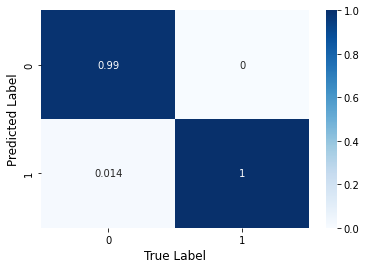

In [92]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 1

In [93]:
predicted_val_logi = logi.predict_proba(test)[:, 1]
winner_lg = pd.concat([BB_marathi_participant, pd.DataFrame(predicted_val_logi, columns=['Predicted_Winner'])],axis=1)
winner_lg.sort_values('Predicted_Winner', ascending=False).style.hide_index()

Name,Predicted_Winner
Amruta Dhongade,0.000727
Prasad Jawade,0.000405
Kiran Mane,0.000341
Akshay Kelkar,0.000164
Apurva Nemlekar,0.000083
Aroh Velankar,0.000034
Vishal Nikam,0.000025
Mira Jagannath,0.000019
Tejaswini Lonari,0.000013
Rakhi Sawant,0.000004


## 💥 Predicted Winner for Bigg Boss Marathi Season 4, as per Logistic Regression

In [94]:
# Predicted Winner for Bigg Boss Marathi 4 Season, as per LogisticRegression
winner_lg[winner_lg['Predicted_Winner'] == np.amax(winner_lg.Predicted_Winner)].style.hide_index()

Name,Predicted_Winner
Amruta Dhongade,0.000727


In [95]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=2022).fit(x_train, y_train)
rf

RandomForestClassifier(n_estimators=200, random_state=2022)

In [96]:
predicted_val_rf = rf.predict_proba(x_val)[:, 1]
y_predicted_val = (predicted_val_rf > 0.3).astype("int").ravel()
print('F1 Score -', f1_score(y_val, y_predicted_val, average='weighted')*100)
print('Accuracy Score -', accuracy_score(y_val, y_predicted_val)*100)

# n_estimators=100 accuracy 97.00

F1 Score - 98.3620239958268
Accuracy Score - 98.22222222222223


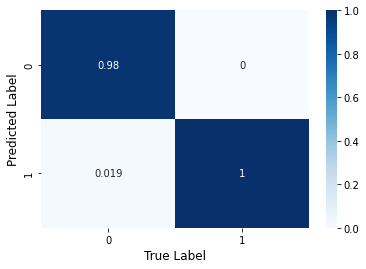

In [97]:
# Confusion Matrix
plot_confusion_matrix()

# TP 1 TN 1

In [98]:
predicted_val_rf = rf.predict_proba(test)[:, 1]
winner_rf = pd.concat([BB_marathi_participant, pd.DataFrame(predicted_val_rf, columns=['Predicted_Winner'])],axis=1)
winner_rf.sort_values('Predicted_Winner', ascending=False).style.hide_index()

Name,Predicted_Winner
Amruta Dhongade,0.035000
Apurva Nemlekar,0.035000
Akshay Kelkar,0.030000
Kiran Mane,0.020000
Prasad Jawade,0.005000
Tejaswini Lonari,0.000000
Aroh Velankar,0.000000
Mira Jagannath,0.000000
Rakhi Sawant,0.000000
Vishal Nikam,0.000000


## 💥 Predicted Winner for Bigg Boss Marathi Season 4, as per Random Forest

In [99]:
# Predicted Winner for Bigg Boss Marathi 4 Season, as per RandomForest
winner_rf[winner_rf['Predicted_Winner'] == np.amax(winner_rf.Predicted_Winner)].style.hide_index()

Name,Predicted_Winner
Amruta Dhongade,0.035000
Apurva Nemlekar,0.035000


## 🚀 Machine Learning (ML) models to predict Indian BiggBoss (Big Brother) season Winners

## Hindi Bigg Boss Season16
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-hindi-season-16-winner

## Kannada Bigg Boss Season9
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-kannada-season-9-winner

## Telugu Bigg Boss Season6
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-telugu-season-6-winner

## Tamil Bigg Boss Season6
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-tamil-season-6-winner

## Malayalam Bigg Boss Season4
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-malayalam-season-4-winner

## Bangla Bigg Boss Season3
## https://www.kaggle.com/code/thirumani/predicting-bigg-boss-bangla-season-3-winner

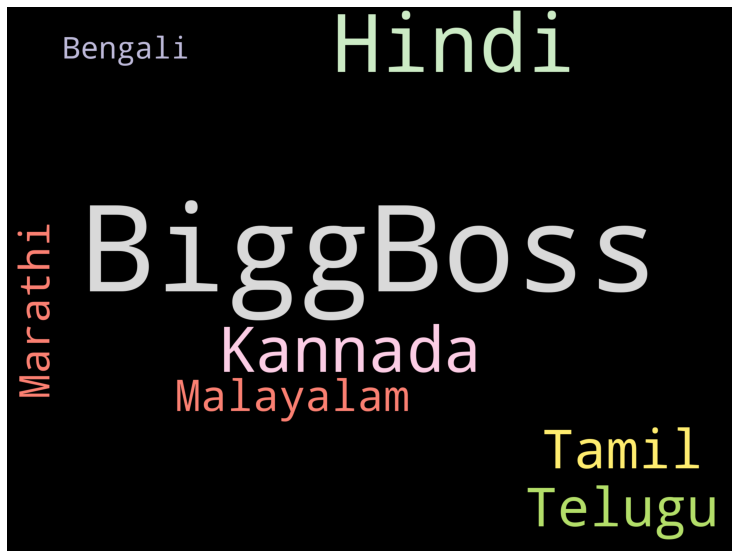

In [100]:
# Word cloud of Bigg Boss
text = " BiggBoss ".join(cat for cat in bigg_boss['Language'])
wordcloud = WordCloud(width=2000, height=1500, background_color='Black', colormap='Set3', collocations=False, random_state=2022).generate(text)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [101]:
print("numpy version: {}". format(np.__version__))
print("pandas version: {}". format(pd.__version__))
import matplotlib
print("matplotlib version: {}". format(matplotlib. __version__))
print("seaborn version: {}". format(sns.__version__))
import sklearn
print("sklearn version: {}". format(sklearn.__version__))
import plotly
print("plotly version: {}". format(plotly.__version__))

# Current versions
# numpy version: 1.21.6
# pandas version: 1.3.5
# matplotlib version: 3.5.3
# seaborn version: 0.11.2
# sklearn version: 1.0.2
# plotly version: 5.10.0

numpy version: 1.21.6
pandas version: 1.3.5
matplotlib version: 3.5.3
seaborn version: 0.11.2
sklearn version: 1.0.2
plotly version: 5.10.0
